# Random Forest Regressor

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utils.utils import apply_one_hot_encoding, full_categorical_columns, align_features, numerical_columns, evaluate_model, remove_outliers, apply_scaling, total_columns_to_check
from utils.model import save_model
from utils.graph import plot_actual_vs_predicted
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
# Load the cleaned data
train_data = pd.read_csv("data/cleaned_Train.csv")

# Remove outliers
train_data = remove_outliers(train_data, columns=total_columns_to_check, method='iqr')

target_column = 'total_cost'

train_data[target_column] = np.log1p(train_data[target_column])

# Apply one-hot encoding for categorical features
X = apply_one_hot_encoding(train_data, target_column=target_column, categorical_columns=full_categorical_columns)
y = train_data[target_column]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
# Initialize the Random Forest Regressor
random_forest_model = RandomForestRegressor(
    n_estimators=100,   # Default number of trees
    random_state=42,
    n_jobs=-1           # Use all available CPU cores
)

# Train the model
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [125]:
# Make predictions on validation set
y_val_pred = random_forest_model.predict(X_val)

# Evaluate the model
metrics = evaluate_model(y_val, y_val_pred)

Validation Set Metrics:
Mean Absolute Error (MAE): 0.8042541186093759
Mean Squared Error (MSE): 1.1373146998084258
Root Mean Squared Error (RMSE): 1.0664495767772735
R² Score: 0.5262791019716252


In [126]:
# Cross-Validation with Random Forest
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='r2')
# Print results
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", np.mean(cv_scores))
print("Standard Deviation of R² Score:", np.std(cv_scores))

Cross-Validation R² Scores: [0.49838366 0.51087905 0.47381303 0.47075053 0.498253  ]
Mean R² Score: 0.4904158557048053
Standard Deviation of R² Score: 0.015530794202926928


### Model Performance Summary (Non-Technical Explanation)

---

**1. Prediction Errors (Average Deviation):**  
- On average, the predictions made by the model differ from the actual total cost by around **5 million TZS**.  
- Some predictions are closer to the actual cost, but others are quite far off.

---

**2. How Large the Errors Are:**  
- The **Root Mean Squared Error (RMSE)** is about **9.4 million TZS**.  
- This tells us that the errors between the predicted and actual total costs are, on average, about **9 million TZS**, which is quite high.

---

**3. Model's Explanation of Data (R² Score):**  
- The **R² Score** is **37%**, which means the model only explains about **37% of the variations** in total cost.  
- Ideally, a score closer to **100%** would mean the model perfectly predicts the total cost. However, at 37%, the model struggles to capture the patterns in the data.

---

### What Does This Mean?  
- The model is not performing very well because it is **underfitting** the data.  
- It’s like trying to guess the cost of a trip without understanding all the key factors, such as group size, country, or number of nights spent.  
- The predictions are inconsistent and sometimes far from the actual cost.

---

### Possible Reasons:  
1. **Not Enough Complexity**: The model might need more adjustments (like tweaking its settings) to better fit the data.  
2. **Data Issues**: There might be unusual values (outliers) or missing information in the data that confuse the model.  
3. **Missing Patterns**: Some important relationships between factors (like group size or purpose of travel) might not be well understood by the model.

---

### Next Steps to Improve the Model:  
1. **Fine-tune the model** by adjusting its settings to make it more accurate.  
2. **Clean the data further** by handling unusual values that might distort predictions.  
3. **Add new insights**: Look for additional factors (like season, trip arrangements) that could explain costs better.  
4. **Try other models**: Use different algorithms (like Gradient Boosting or XGBoost) that may work better with the data.

---

### In Simple Terms:  
The current model tries to predict the total cost but is still **far from accurate**. We need to make it smarter and cleaner to get better results. 🚀

## Implementing Improvements

### Hyperparameter Tuning
### Hyperparameters using GridSearchCV:

In [127]:
# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],   # Number of trees
    'max_depth': [10, 20, None],      # Maximum tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]     # Minimum samples per leaf
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

# Train using Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [128]:
# Evaluate the tuned model
y_val_pred = best_rf_model.predict(X_val)
metrics = evaluate_model(y_val, y_val_pred)

Validation Set Metrics:
Mean Absolute Error (MAE): 0.7667331538537049
Mean Squared Error (MSE): 1.06514947256073
Root Mean Squared Error (RMSE): 1.0320607891789757
R² Score: 0.556337779894243


In [129]:
# Cross-Validation with Random Forest
cv_scores_grid = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='r2')
# Print results
print("Cross-Validation R² Scores:", cv_scores_grid)
print("Mean R² Score:", np.mean(cv_scores_grid))
print("Standard Deviation of R² Score:", np.std(cv_scores_grid))

Cross-Validation R² Scores: [0.51198299 0.54160215 0.51374917 0.48394428 0.53525882]
Mean R² Score: 0.5173074824064662
Standard Deviation of R² Score: 0.020330256683476506


### Summary of Improvement
The updated model shows slight improvements across all metrics. While it is still far from ideal, the reduction in MAE and RMSE and the increase in the R² score suggest the model is learning better relationships in the data. This progress is encouraging and shows that there’s potential for further improvement through fine-tuning or feature engineering.

### Addressing Underfitting in Random Forest Regressor with GridSearchCV
Hhe model seems to be underfitting (as suggested by relatively low R² scores and high RMSE), it means the model is too simplistic to capture the patterns in the data. Here's how we can use GridSearchCV to tune hyperparameters and improve the model:

## Exploring the data to identify which columns or features might be causing underfitting

In [130]:
# Get feature importance from the trained Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top features
with pd.option_context('display.max_rows', None):
    print(feature_importance_df.head(84))

                                               Feature  Importance
133                      tour_arrangement_Package Tour    0.275346
6                                         total_nights    0.165032
135                           package_accomodation_Yes    0.111129
112                       purpose_Leisure and Holidays    0.109365
4                                      country_encoded    0.040938
5                                         total_people    0.039176
2                                       night_mainland    0.026264
95                                      country_UGANDA    0.021957
122                      main_activity_Hunting tourism    0.019376
116             purpose_Visiting Friends and Relatives    0.015026
3                                       night_zanzibar    0.014010
141                           payment_mode_Credit Card    0.009134
115                    purpose_Scientific and Academic    0.007474
45                                       country_KENYA    0.00

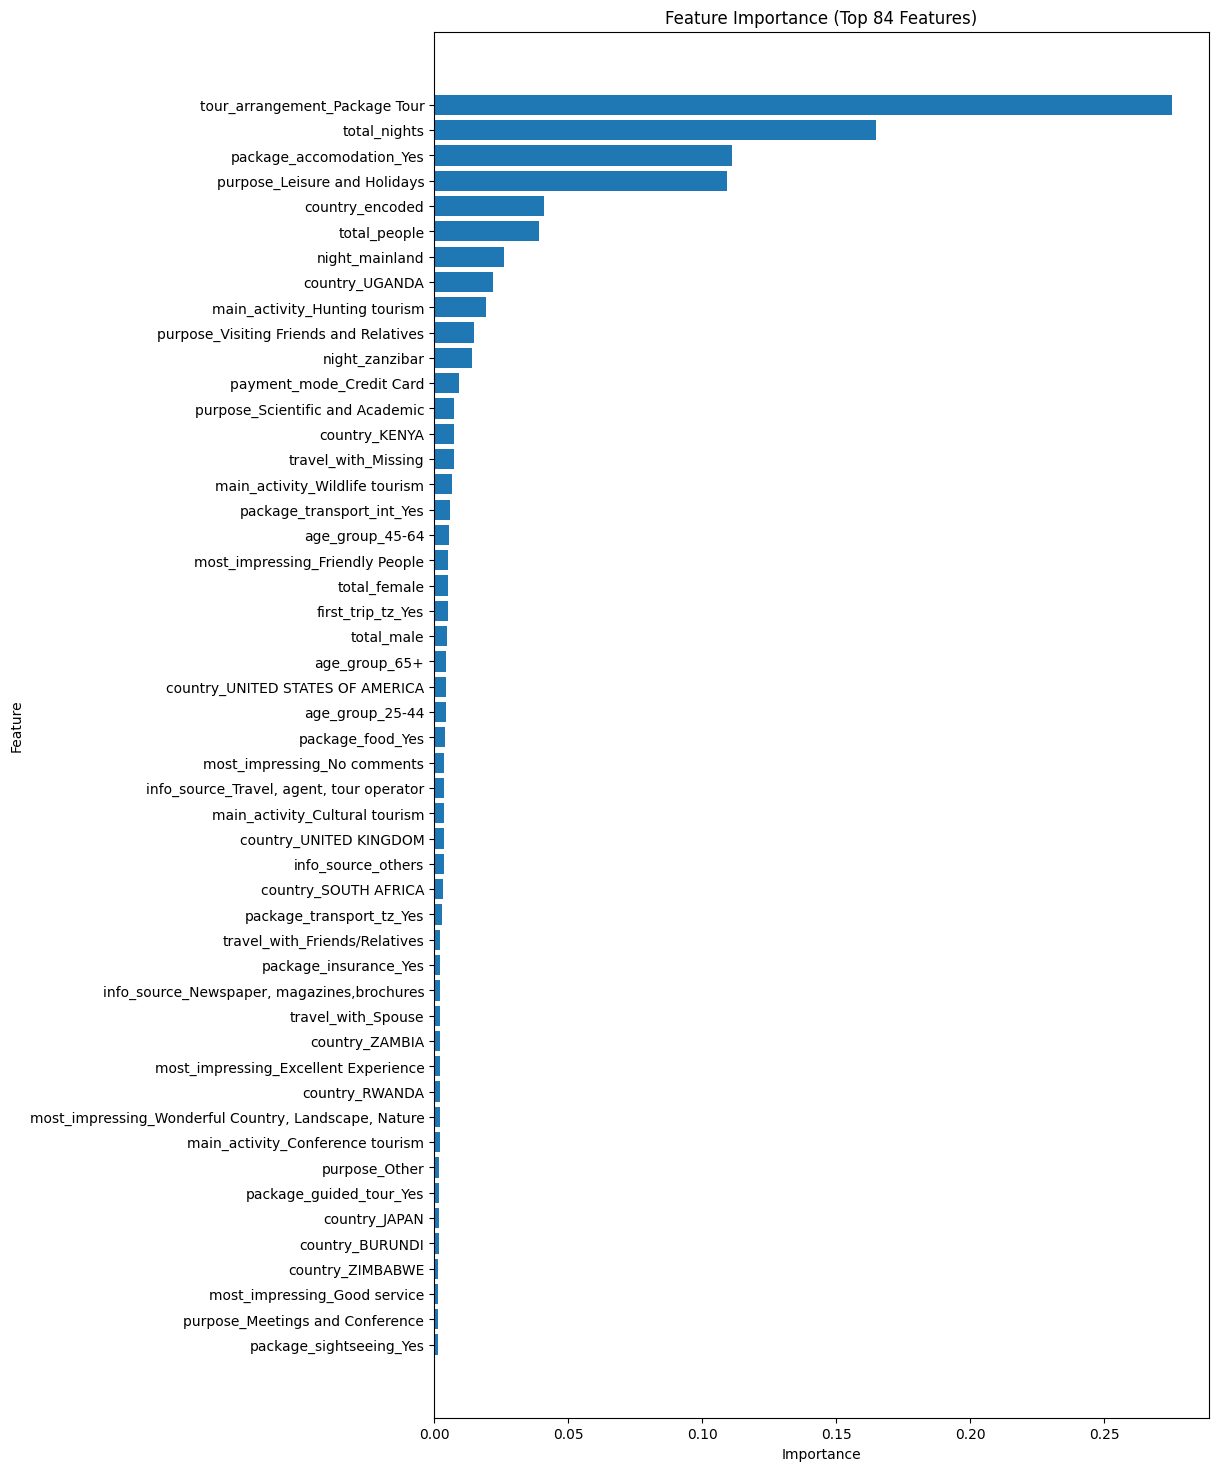

In [131]:
# Visualize feature importance
# Slice the DataFrame to include only the first 84 rows
top_84_features = feature_importance_df.head(50)

# Plot the top 84 features
plt.figure(figsize=(10, 18))
plt.barh(top_84_features['Feature'], top_84_features['Importance'])
plt.title("Feature Importance (Top 84 Features)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [132]:
# Focus on High-Importance Features
# Identify and prioritize features with the highest importance scores (e.g., above a threshold like 0.01 or 0.05).
top_n = 50
important_features = feature_importance_df.nlargest(top_n, 'Importance')['Feature']
X_train_important = X_train[important_features]
X_val_important = X_val[important_features]

In [133]:
# Analyze Low-Importance Features
# Features with very low importance (close to 0.0) may not add value to the model and could introduce noise.
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.001]['Feature']

X_train_reduced = X_train.drop(columns=low_importance_features)
X_val_reduced = X_val.drop(columns=low_importance_features)

In [134]:
# Retrain model with important features only
rf_model_important = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search_important = GridSearchCV(
    estimator=rf_model_important,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

# Train using Grid Search
grid_search_important.fit(X_train_important, y_train)

# Get the best parameters and model
best_rf_model_important = grid_search_important.best_estimator_
print("Best Parameters:", grid_search_important.best_params_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [135]:
# Evaluate the tuned model
y_val_pred_important = best_rf_model_important.predict(X_val_important)
metrics = evaluate_model(y_val, y_val_pred_important)

Validation Set Metrics:
Mean Absolute Error (MAE): 0.7683262866568604
Mean Squared Error (MSE): 1.069041048760479
Root Mean Squared Error (RMSE): 1.0339444128000688
R² Score: 0.5547168380631021


In [136]:
# Cross-Validation with Random Forest
cv_scores_grid_important = cross_val_score(best_rf_model_important, X_train_important, y_train, cv=5, scoring='r2')
# Print results
print("Cross-Validation R² Scores:", cv_scores_grid_important)
print("Mean R² Score:", np.mean(cv_scores_grid_important))
print("Standard Deviation of R² Score:", np.std(cv_scores_grid_important))

Cross-Validation R² Scores: [0.51339493 0.54153365 0.51610879 0.48294374 0.53496973]
Mean R² Score: 0.5177901678276722
Standard Deviation of R² Score: 0.02047099907436621


In [138]:
# This is too long to be trained and also the evaluation is not great
# Retrain model with important features only
# rf_model_rfe = RandomForestRegressor(random_state=42, n_jobs=-1)

# rfe = RFE(estimator=rf_model_rfe, n_features_to_select=15, step=1)  # Adjust n_features_to_select as needed

# rfe_param_grid = {
#     'rfe__n_features_to_select': [10, 15],  # Number of features to select in RFE
#     'randomforest__n_estimators': [50],    # Number of trees
#     'randomforest__max_depth': [10],  # Maximum depth of trees
# }

# # Create a pipeline combining RFE and Random Forest
# pipeline = Pipeline([
#     ('rfe', rfe),  # Step 1: Recursive Feature Elimination
#     ('randomforest', rf_model_rfe)  # Step 2: Random Forest model
# ])

# # Use GridSearchCV to tune the pipeline
# grid_search_rfe = GridSearchCV(
#     estimator=pipeline,
#     param_grid=rfe_param_grid,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=2
# )

# # Train the pipeline using GridSearchCV
# grid_search_rfe.fit(X_train, y_train)

# # Best model and parameters
# best_rf_model_rfe = grid_search_rfe.best_estimator_
# print("Best Parameters:", grid_search_rfe.best_params_)

# Step 6: Evaluate the model
# y_val_pred_rfe = best_rf_model_rfe.predict(X_val)

# # Evaluate performance
# metrics_rfe = evaluate_model(y_val, y_val_pred_rfe)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'randomforest__max_depth': 10, 'randomforest__n_estimators': 50, 'rfe__n_features_to_select': 15}
Validation Set Metrics:
Mean Absolute Error (MAE): 0.8090038487085348
Mean Squared Error (MSE): 1.1383380643330514
Root Mean Squared Error (RMSE): 1.0669292686645406
R² Score: 0.5258528442597556


In [140]:
# Cross-Validation with Random Forest
# cv_scores_grid_rfe = cross_val_score(best_rf_model_rfe, X_train, y_train, cv=5, scoring='r2')
# # Print results
# print("Cross-Validation R² Scores:", cv_scores_grid_rfe)
# print("Mean R² Score:", np.mean(cv_scores_grid_rfe))
# print("Standard Deviation of R² Score:", np.std(cv_scores_grid_rfe))

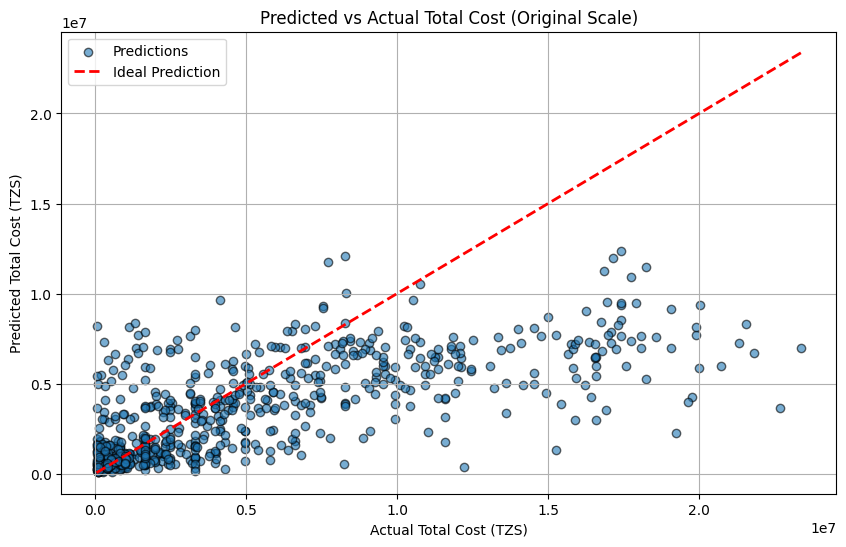

In [142]:
# Convert log-transformed values back to original scale
y_val_actual = np.expm1(y_val)  # Exponentiate actual values
y_val_pred_actual = np.expm1(y_val_pred_important)  # Exponentiate predicted values

# Plot Predicted vs Actual on the original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, y_val_pred_actual, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2, label="Ideal Prediction")
plt.title("Predicted vs Actual Total Cost (Original Scale)")
plt.xlabel("Actual Total Cost (TZS)")
plt.ylabel("Predicted Total Cost (TZS)")
plt.legend()
plt.grid(True)
plt.show()


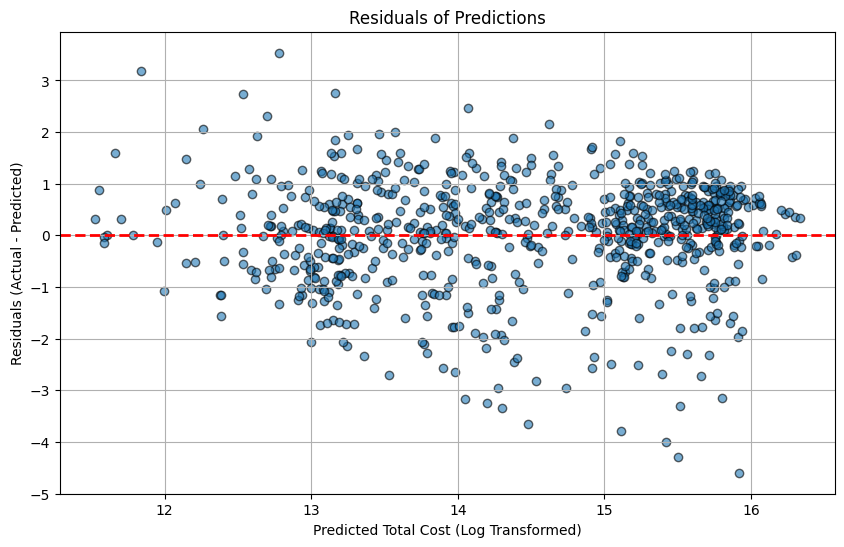

In [143]:
residuals = y_val - y_val_pred_important
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_important, residuals, alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("Residuals of Predictions")
plt.xlabel("Predicted Total Cost (Log Transformed)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


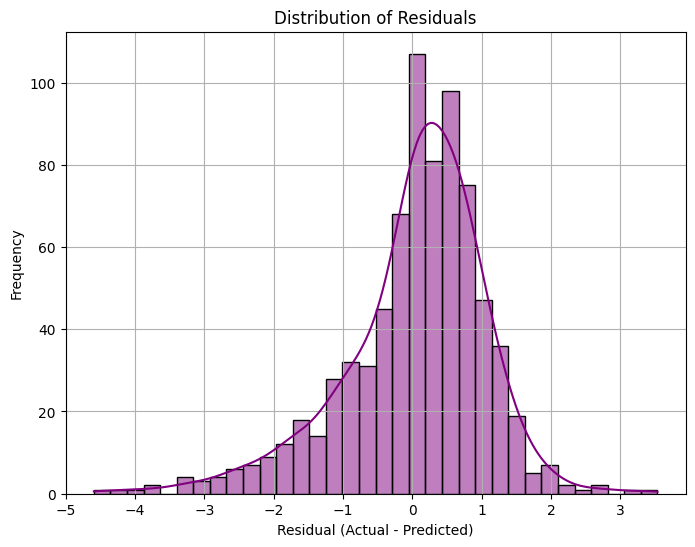

In [144]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

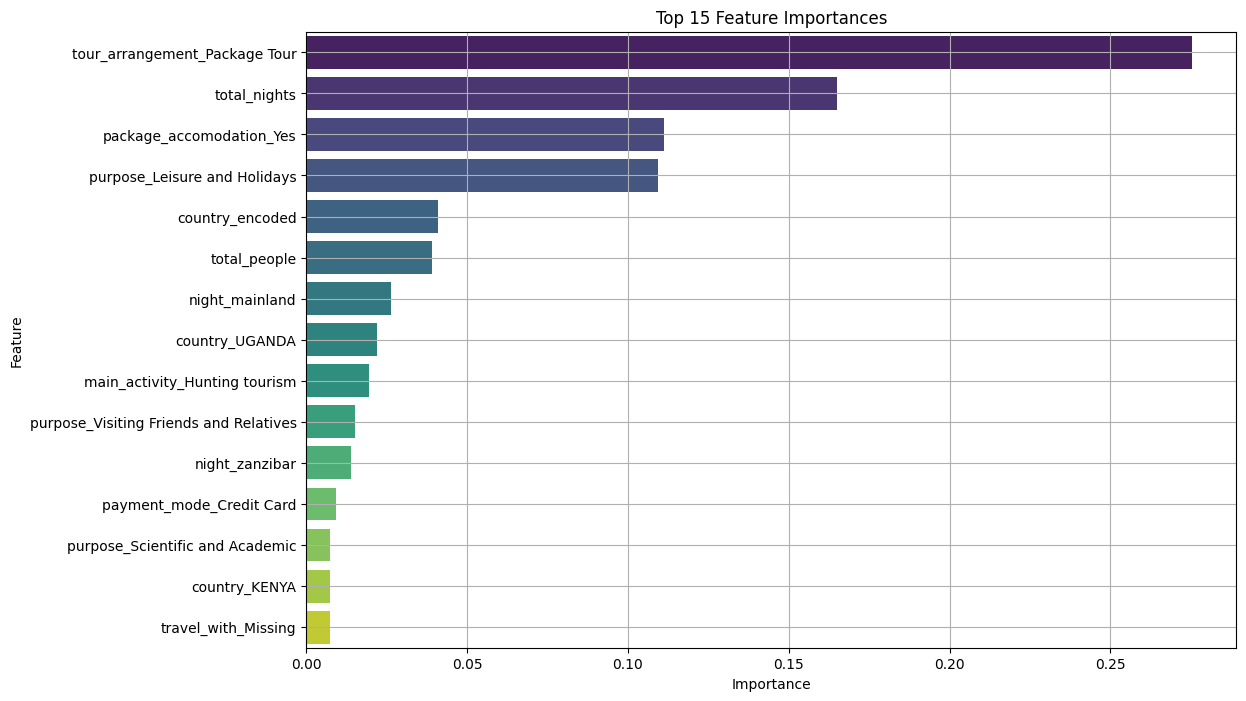

In [145]:
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)  # Top 15 features
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


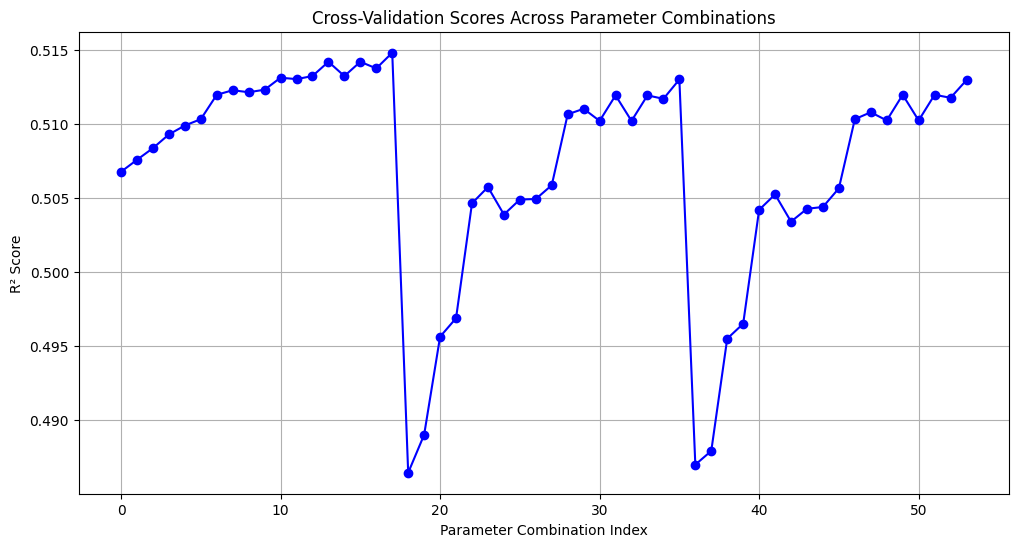

In [146]:
cv_scores = grid_search_important.cv_results_['mean_test_score']
cv_params = grid_search_important.cv_results_['params']

plt.figure(figsize=(12, 6))
plt.plot(range(len(cv_scores)), cv_scores, marker='o', linestyle='-', color='b')
plt.title("Cross-Validation Scores Across Parameter Combinations")
plt.xlabel("Parameter Combination Index")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()


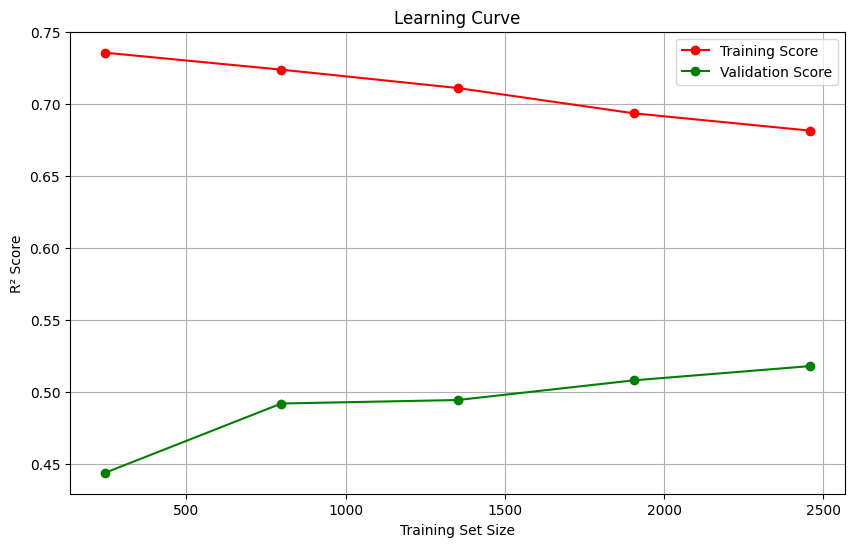

In [147]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model_important, X_train_important, y_train, cv=5, scoring='r2', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()


In [ ]:
# Save best random forest model then
# Assume 'model' is your trained model
save_model(best_rf_model_important, 'models/best_c.pkl')